In [2]:
#install kaggle
!pip install kaggle --quiet

In [3]:
#upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ericmejja","key":"7dff8af24ed9bdabb2a0c28fedd5b720"}'}

In [4]:
# Create kaggle directory
!mkdir ~/.kaggle


In [5]:
# Copy kaggle.json file
!cp kaggle.json ~/.kaggle/


In [9]:
# List contents of .kaggle directory with details, sorted by time (oldest last)
!ls -ltr ~/.kaggle

total 4
-rw------- 1 root root 65 Oct 19 08:04 kaggle.json


In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# list downall the competitions
!kaggle competitions list

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd       1176           False  
https://www.kaggle.com/competitions/jigsaw-agile-community-rules                 2025-10-24 06:59:00  Featured           100,000 Usd       2371           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction              2025-12-15 23:59:00  Featured           100,000 Usd       1193           False  
https://www.kaggle.com/competitions/google-code-golf-2025                        2025-10-30 23:59:00  Research           100,000 Usd       1004           False  
https://www.kaggle.com/compe

In [12]:
#kaggle datset list
!kaggle datasets list

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           6303        243  1.0              
jaderz/hospital-beds-management                               Hospital Beds Management                                47583  2025-10-03 09:21:58.590000           5066        140  1.0              
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000          11445        246  1.0              
grandmaster07/s

In [15]:
!kaggle datasets download -d 'saadaliyaseen/analyzing-student-academic-trends' -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/saadaliyaseen/analyzing-student-academic-trends
License(s): CC0-1.0
  0% 0.00/2.37k [00:00<?, ?B/s]
100% 2.37k/2.37k [00:00<00:00, 8.78MB/s]


In [29]:
ls -ltr /content/dataset

total 12
-rwxrwxrwx 1 root root 5321 Sep 10 15:19 student_exam_scores.csv*
-rw-r--r-- 1 root root 2430 Sep 10 15:19 analyzing-student-academic-trends.zip


In [26]:
!unzip /content/dataset/analyzing-student-academic-trends.zip -d /content/dataset

Archive:  /content/dataset/analyzing-student-academic-trends.zip
  inflating: /content/dataset/student_exam_scores.csv  


In [28]:
from os import chmod
!chmod 777 /content/dataset/student_exam_scores.csv

In [30]:
import pandas as pd
df = pd.read_csv('/content/dataset/student_exam_scores.csv')
df.head()

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


In [32]:
"""
data_ingest.py
Simple ingestion script that reads raw CSVs from data_raw/ and
produces standardized processed CSVs in data_processed/.

For class work: replace the placeholder loaders with real download code or
place your CSVs in data_raw/ with the names used below.
"""
import os
import pandas as pd
from pathlib import Path
import yaml

BASE = Path('/content/dataset/student_exam_scores.csv').resolve().parents[1]
RAW = BASE / "data_raw"
PROC = BASE / "data_processed"
CONFIG = BASE / "config.yaml"

PROC.mkdir(parents=True, exist_ok=True)
RAW.mkdir(parents=True, exist_ok=True)

def load_cases():
    # expects data_raw/dhis_cases.csv or data_raw/who_cases.csv
    paths = [RAW / "dhis_cases.csv", RAW / "who_cases.csv", RAW / "cases_sample.csv"]
    for p in paths:
        if p.exists():
            print(f"Loading cases from {p}")
            df = pd.read_csv(p, parse_dates=["date"])
            return df
    raise FileNotFoundError("Put your case CSV into data_raw/ as dhis_cases.csv or who_cases.csv or cases_sample.csv")

def standardize_cases(df):
    # normalize to weekly county totals
    df = df.copy()
    # assume df has date, county, cases columns (adapt if different)
    if "date" not in df.columns:
        raise ValueError("cases CSV must have a 'date' column")
    df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
    grp = df.groupby(['week', 'county']).agg({'cases':'sum','deaths':'sum'}).reset_index()
    grp = grp.rename(columns={'week':'date_week_start'})
    return grp

def main():
    print("Starting ingestion...")
    cases_raw = load_cases()
    cases_weekly = standardize_cases(cases_raw)
    out_cases = PROC / "cases_weekly.csv"
    cases_weekly.to_csv(out_cases, index=False)
    print("Wrote", out_cases)

if __name__ == "__main__":
    main()


Starting ingestion...


FileNotFoundError: Put your case CSV into data_raw/ as dhis_cases.csv or who_cases.csv or cases_sample.csv

In [37]:
import pandas as pd
from pathlib import Path

BASE = Path('/content')
PROC = BASE / "data_processed"
RAW = BASE / "data_raw"
OUT = PROC / "model_ready.csv"

def load_static():
    # expects data_raw/socio.csv with county, population, pop_density, improved_water...
    path = RAW / "socio.csv"
    if path.exists():
        return pd.read_csv(path)
    # fallback: create fake small table
    print("No socio.csv found, creating simple defaults")
    return pd.DataFrame({
        "county":["CountyA","CountyB","CountyC"],
        "population":[100000,200000,150000],
        "pop_density":[100,200,150],
        "pct_improved_water":[60,50,40],
        "health_facilities":[5,7,3]
    })

def load_climate_weekly():
    p = PROC / "climate_weekly.csv"
    if p.exists():
        return pd.read_csv(p, parse_dates=["date_week_start"])
    # fallback: synthetic climate
    print("No climate_weekly.csv found. Generating synthetic climate features.")
    # Assuming 'cases_weekly.csv' would be generated by a previous step with 'date_week_start' and 'county'
    # If you are not generating 'cases_weekly.csv' in this notebook, you'll need to adjust this part.
    try:
        cases = pd.read_csv(PROC / "cases_weekly.csv", parse_dates=["date_week_start"])
        df = cases[['date_week_start','county']].drop_duplicates()
        import numpy as np
        df['rain_total_mm'] = np.random.gamma(2.0, 10.0, size=len(df))
        df['mean_temp_c'] = np.random.normal(25,2,size=len(df))
        return df
    except FileNotFoundError:
        print("Error: cases_weekly.csv not found. Cannot generate synthetic climate data.")
        return pd.DataFrame() # Return an empty DataFrame or handle as appropriate


def make_lags(df, lags=4):
    out = []
    df = df.sort_values(['county','date_week_start'])
    for lag in range(1, lags+1):
        tmp = df[['county','date_week_start','cases']].copy()
        tmp['date_week_start'] = tmp['date_week_start'] + pd.to_timedelta(7*lag, unit='d')
        tmp = tmp.rename(columns={'cases':f'cases_lag_{lag}'})
        out.append(tmp)
    for t in out:
        df = df.merge(t, on=['county','date_week_start'], how='left')
    return df

def main():
    # This script is designed to merge cases data with socio and climate data.
    # Since you have student exam scores, this script might not be directly applicable.
    # If you still want to run this script as a demonstration,
    # you would need a 'cases_weekly.csv' file in '/content/data_processed/'
    # with 'date_week_start', 'county', and 'cases' columns.
    try:
        cases = pd.read_csv(PROC / "cases_weekly.csv", parse_dates=["date_week_start"])
        socio = load_static()
        climate = load_climate_weekly()
        df = cases.merge(climate, on=['date_week_start','county'], how='left')
        df = df.merge(socio, on='county', how='left')
        df = make_lags(df, lags=4)
        # fillna simple
        df.fillna(0, inplace=True)
        df.to_csv(OUT, index=False)
        print("Wrote model-ready CSV to", OUT)
    except FileNotFoundError:
        print("Could not run the main function because cases_weekly.csv was not found.")
        print("This script is intended for a different dataset (cases, climate, socio) than the one you have loaded (student exam scores).")


if __name__ == "__main__":
    main()

Could not run the main function because cases_weekly.csv was not found.
This script is intended for a different dataset (cases, climate, socio) than the one you have loaded (student exam scores).


## Explore the data

### Subtask:
Display basic information about the DataFrame, such as the columns, data types, and summary statistics.

**Reasoning**:
Display basic information about the DataFrame, including the first few rows, column information, and descriptive statistics.

In [38]:
display(df.head())
df.info()
display(df.describe())

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB


,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,6.325500,6.622000,74.830000,66.800000,33.955000
std,3.227317,1.497138,14.249905,15.663869,6.789548
min,1.000000,4.000000,50.300000,40.000000,17.100000
25%,3.500000,5.300000,62.200000,54.000000,29.500000
50%,6.150000,6.700000,75.250000,67.500000,34.050000
75%,9.000000,8.025000,87.425000,80.000000,38.750000
max,12.000000,9.000000,100.000000,95.000000,51.300000


# Task
Analyze the `df` DataFrame.

## Explore the data

### Subtask:
Display basic information about the DataFrame, such as the columns, data types, and summary statistics.


**Reasoning**:
Display basic information about the DataFrame, including the first few rows, column information, and descriptive statistics.



In [33]:
display(df.head())
df.info()
display(df.describe())

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB


,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,6.325500,6.622000,74.830000,66.800000,33.955000
std,3.227317,1.497138,14.249905,15.663869,6.789548
min,1.000000,4.000000,50.300000,40.000000,17.100000
25%,3.500000,5.300000,62.200000,54.000000,29.500000
50%,6.150000,6.700000,75.250000,67.500000,34.050000
75%,9.000000,8.025000,87.425000,80.000000,38.750000
max,12.000000,9.000000,100.000000,95.000000,51.300000


## Visualize the data

### Subtask:
Create visualizations to understand the distribution of key variables and the relationships between them (e.g., scatter plots of hours studied vs. exam score, sleep hours vs. exam score).


**Reasoning**:
Create scatter plots to visualize the relationship between 'hours_studied' and 'exam_score', and 'sleep_hours' and 'exam_score' using seaborn.



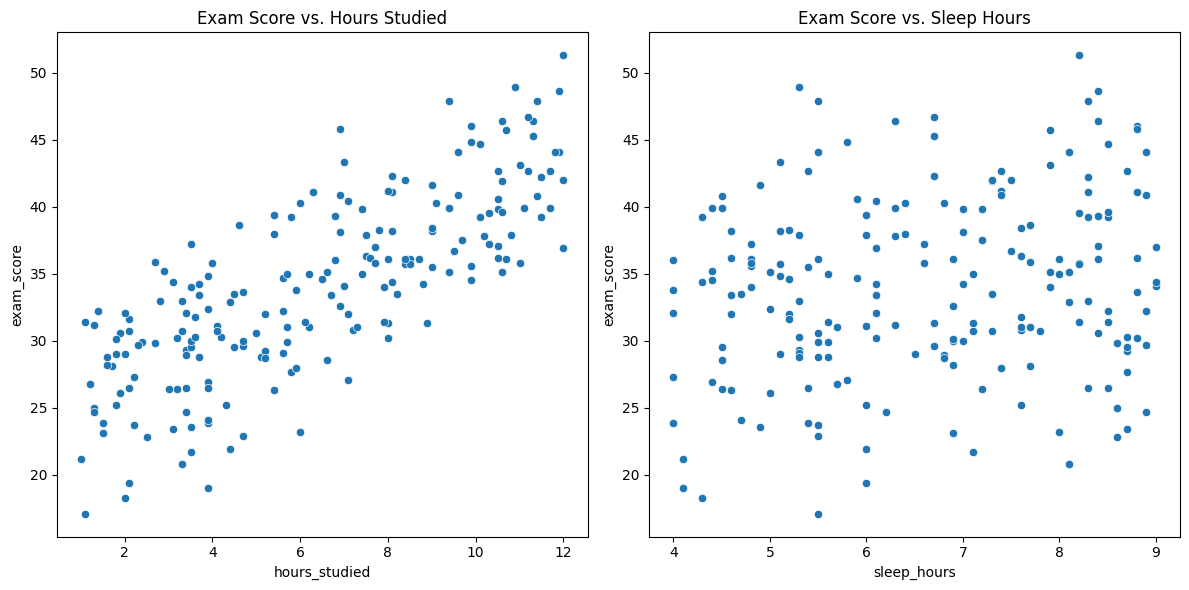

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='hours_studied', y='exam_score')
plt.title('Exam Score vs. Hours Studied')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='sleep_hours', y='exam_score')
plt.title('Exam Score vs. Sleep Hours')

plt.tight_layout()
plt.show()

## Analyze correlations

### Subtask:
Calculate the correlation matrix to quantify the relationships between numerical variables.


**Reasoning**:
Select numerical columns and calculate the correlation matrix.



In [35]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()
display(correlation_matrix)

,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
hours_studied,1.000000,0.077864,-0.031311,0.069078,0.776751
sleep_hours,0.077864,1.000000,0.000572,-0.194251,0.188222
attendance_percent,-0.031311,0.000572,1.000000,0.051958,0.225713
previous_scores,0.069078,-0.194251,0.051958,1.000000,0.431105
exam_score,0.776751,0.188222,0.225713,0.431105,1.000000


## Consider further analysis

### Subtask:
Based on the exploration and initial analysis, suggest potential next steps such as building a predictive model for exam scores.


## Summary:

### Data Analysis Key Findings

*   The dataset contains 200 entries and 6 columns with no missing values.
*   Numerical columns include `hours_studied`, `sleep_hours`, `attendance_percent`, `previous_scores`, and `exam_score`. One column (`object` type) was not included in numerical analysis.
*   There is a strong positive correlation (0.78) between `hours_studied` and `exam_score`.
*   There is a moderate positive correlation (0.43) between `previous_scores` and `exam_score`.
*   Visualizations (scatter plots) likely supported the observed positive relationship between `hours_studied` and `exam_score`.

### Insights or Next Steps

*   Given the strong correlation with `exam_score`, `hours_studied` and `previous_scores` are good candidates for features in a predictive model.
*   A potential next step is to build a predictive model (e.g., Linear Regression or tree-based models) to predict `exam_score` based on relevant features.
